In [28]:
# Data Analysis Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# For NLP Tasks
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

#  Library for Oversampling
import imblearn
from imblearn.over_sampling import RandomOverSampler

# For Building Models
import tensorflow as tf
from tensorflow.keras.layers import LSTM,Embedding,Dense,Bidirectional
from tensorflow.keras.models import Sequential

# For Tokenizing Texts
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# For suppresing warnings
import warnings
warnings.filterwarnings('ignore')

tf.random.set_seed(1)
np.random.seed(1)

In [2]:
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

**Mounting Drive**

In [3]:
from google.colab import drive
drive.mount('/content/drive/')
# !cd 'drive/MyDrive/ZS_Data_Science_Challenge'

Mounted at /content/drive/


**Relevant Training Data**

In [4]:
def clean_text(text):
  '''
  Cleaning Data to feed as an input to the model
  
  '''
  text = text.lower()
  # text = re.sub('[^a-zA-Z]',' ',text)
  text = re.sub(r'[^\w\s]', '', text)
  text_list = text.split(' ')

  #StopWord Removal
  stopwords_list = stopwords.words('english')
  clean_text_list = [word for word in text_list if not word in stopwords_list]
  
  # Lemmatization
  lemmatizer = WordNetLemmatizer()
  clean_text_list = [lemmatizer.lemmatize(word) for word in clean_text_list]

  clean_text = ' '.join(clean_text_list)
  return clean_text

In [5]:
def tokenize_text(text_list,oov_token='<OOV>'):
  tokenizer = Tokenizer(oov_token=oov_token)
  tokenizer.fit_on_texts(text_list)
  return tokenizer

In [6]:
def train_data_prep(df,input_col,target_col,input_len,oversample_flag=True):
  text_list = list(map(str,df[input_col].values))
  tokenizer = tokenize_text(text_list)
  vocab_len = len(tokenizer.word_index)
  sequences = tokenizer.texts_to_sequences(text_list)
  X = pad_sequences(sequences, padding='post',truncating='post',maxlen=input_len)
  y = df[target_col].values
  if oversample_flag:
    ros = RandomOverSampler()
    Xov,yov = ros.fit_resample(X,y)
    return Xov,yov,tokenizer
  return X,y,tokenizer

In [7]:
def model_architecture_pretrained_embedding(vocab_size,d_model,input_len,embedding_matrix):
  model = Sequential()
  model.add(Embedding(input_dim= vocab_size,output_dim=100,input_length=input_len,embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),trainable=False))
  model.add(Bidirectional(LSTM(d_model)))
  model.add(Dense(1,activation='sigmoid'))
  model.compile(loss='binary_crossentropy',optimizer='adam',metrics='accuracy')
  return model

In [8]:
def create_embedding_matrix(path_to_glove_file,tokenizer,embedding_dim):
  embeddings_index = {}
  with open(path_to_glove_file) as f:
      for line in f:
          word, coefs = line.split(maxsplit=1)
          coefs = np.fromstring(coefs, "f", sep=" ")
          embeddings_index[word] = coefs

  print("Found %s word vectors." % len(embeddings_index))
  num_tokens = len(tokenizer.word_index) + 1
  hits = 0
  misses = 0

  # Prepare embedding matrix
  embedding_matrix = np.zeros((num_tokens, embedding_dim))
  for word, i in tokenizer.word_index.items():
      embedding_vector = embeddings_index.get(word)
      if embedding_vector is not None:
          # Words not found in embedding index will be all-zeros.
          # This includes the representation for "padding" and "OOV"
          embedding_matrix[i] = embedding_vector
          hits += 1
      else:
          misses += 1
  print("Converted %d words (%d misses)" % (hits, misses))
  return embedding_matrix

In [9]:
def train_model_pretrained(df,input_col,target_col,d_model,path_to_glove_file,embedding_dim,input_len=-1,epochs = 50,batch_size=32,oversample_flag=True):
  if input_len==-1:
    df['len'] = df[input_col].apply(lambda x: len(x.split(' ')))
    input_len = df['len'].max()
  X,y,tokenizer = train_data_prep(df,input_col,target_col,input_len,oversample_flag=True)
  embedding_matrix = create_embedding_matrix(path_to_glove_file,tokenizer,embedding_dim)
  vocab_len = len(tokenizer.word_index)
  model = model_architecture_pretrained_embedding(vocab_len+1,d_model,input_len,embedding_matrix)
  history = model.fit(X,y,batch_size=batch_size,epochs=epochs,validation_split=0.05,verbose=1)
  return history,model,tokenizer,input_len

In [10]:
def generate_prediction(text,model,tokenizer,input_len):
  text_clean = clean_text(text)
  seq = tokenizer.texts_to_sequences([text_clean])
  xtest = pad_sequences(seq, padding='post',truncating='post',maxlen=input_len)
  ypred = model.predict(xtest)
  return ypred

In [11]:
def generate_prediction_from_list(text_list,model,tokenizer,input_len):
  text_clean_list = []
  for text in text_list:
    text_clean = clean_text(text)
    text_clean_list.append(text_clean)
  seq = tokenizer.texts_to_sequences(text_clean_list)
  xtest = pad_sequences(seq, padding='post',truncating='post',maxlen=input_len)
  ypred = model.predict(xtest)
  ypred_one_hot = [1 if i>0.5 else 0 for i in ypred]
  return ypred_one_hot

**Loading And Analysing Training Data**

In [12]:
train_path = 'drive/MyDrive/ZS_Data_Science_Challenge/dataset/train.csv'
df = pd.read_csv(train_path,encoding='latin')

In [13]:
df.isnull().sum()

Source               0
Host                59
Link                 0
Date(ET)             0
Time(ET)             0
time(GMT)          161
Title              216
TRANS_CONV_TEXT      1
Patient_Tag          0
dtype: int64

In [14]:
df.shape

(1157, 9)

In [15]:
index_with_nans = df[df.isna().any(axis=1)].index
df.drop(index_with_nans,axis=0,inplace=True)
target_col = 'Patient_Tag'
df.reset_index(drop=True,inplace=True)
df[target_col].value_counts()

0    801
1    125
Name: Patient_Tag, dtype: int64

**Building and training a model**

In [16]:
# input_col = 'TRANS_CONV_TEXT'
# target_col = 'Patient_Tag'
# d_model = 30
# df['text'] = df[input_col].apply(lambda x:clean_text(x))
# history,model,tokenizer,input_len = train_model(df,'text',target_col,d_model,epochs=5)

In [17]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2021-03-22 14:38:37--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-03-22 14:38:38--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-03-22 14:38:38--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

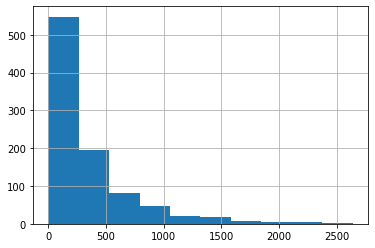

In [19]:
path_to_glove_file = "glove.6B.100d.txt"
embedding_dim = 100
input_col = 'TRANS_CONV_TEXT'
target_col = 'Patient_Tag'
d_model = 100
input_len= 300
df['text'] = df[input_col].apply(lambda x:clean_text(x))
df['len'] = df[input_col].apply(lambda x:len(x.split(' ')))
df['len'].hist()

In [21]:
# Training A BiLSTM Model
history,model,tokenizer,input_len = train_model_pretrained(df,'text',target_col,d_model,path_to_glove_file,embedding_dim,input_len,epochs=25)

Found 400000 word vectors.
Converted 16957 words (5854 misses)
Epoch 1/25
48/48 [==============================] - 22s 386ms/step - loss: 0.6056 - accuracy: 0.6586 - val_loss: 0.3099 - val_accuracy: 0.8765
Epoch 2/25
48/48 [==============================] - 18s 371ms/step - loss: 0.3731 - accuracy: 0.8492 - val_loss: 0.2289 - val_accuracy: 0.9012
Epoch 3/25
48/48 [==============================] - 18s 369ms/step - loss: 0.2635 - accuracy: 0.8927 - val_loss: 0.1822 - val_accuracy: 0.9383
Epoch 4/25
48/48 [==============================] - 18s 370ms/step - loss: 0.2177 - accuracy: 0.9165 - val_loss: 0.3403 - val_accuracy: 0.8765
Epoch 5/25
48/48 [==============================] - 18s 368ms/step - loss: 0.2242 - accuracy: 0.9203 - val_loss: 1.3460 - val_accuracy: 0.2840
Epoch 6/25
48/48 [==============================] - 18s 375ms/step - loss: 0.3795 - accuracy: 0.8390 - val_loss: 0.1773 - val_accuracy: 0.9383
Epoch 7/25
48/48 [==============================] - 20s 415ms/step - loss: 0.20

In [22]:
text = df['text'][9]
print(generate_prediction(text,model,tokenizer,input_len))

[[8.6009976e-08]]


In [23]:
test_data_path = 'drive/MyDrive/ZS_Data_Science_Challenge/dataset/test.csv'
dftest = pd.read_csv(test_data_path)

In [24]:
dftest['text'] = dftest[input_col].apply(lambda x:clean_text(x))
text_list = list(map(str,dftest['text'].values))
pred = generate_prediction_from_list(text_list,model,tokenizer,input_len)

In [26]:
dftest[target_col] = pred
dfnew = dftest[['Index',target_col]]
dfnew.to_csv('submission_2.csv',index=False)

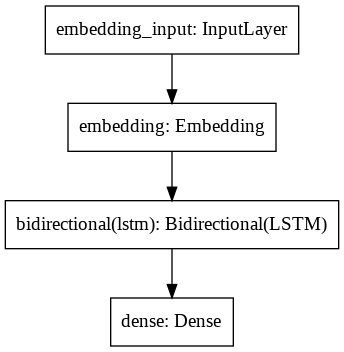

In [27]:
tf.keras.utils.plot_model(model)